## How and Why does Batch Normalization Work? 
In this experiment, we will train a fully-connected deep neural network on the MNIST dataset. Then, we will add a batch normalization layer and compare the performance. 
Finally, we will try to understand how and why batch normalization works.

### What is Batch Normalization? 


Batch normalization is an operation that is usually performed after the linear transformation in a neural network layer but before the activation function. 
##### Training Phase
First, each output or feature is normalized using the feature-wise minibatch summary statistics ($\mu_B^{(i)}$, $\sigma_B^{(i)}$) ($\epsilon$ is a small constant to avoid numerical underflow errors).

$$
\hat{x}^{(i)} = \frac{x^{(i) -\mu_{B}^{(i)}}}{\sqrt{(\sigma_B^{(i)})^2 + \epsilon}}
$$

The layer has two learnable parameters, $\gamma$ and $\beta$, which are then used to scale and shift the normalized features.

$$
\hat{x}^{(i)} = \gamma^{(i)} . \hat{x}^{(i)} + \beta^{(i)}
$$


##### Testing Phase

At test time, the layer uses saved statistics from the training phase along with the learned parameters to perform the transformation.



### Let's start by loading the MNIST dataset

MNIST consists of 70,000 images of handwritten digits, where each image is a 28x28 grayscale pixel grid. The dataset is split into 60,000 training examples and 10,000 test examples, with labels ranging from 0 to 9. Each image in MNIST represents a single digit written by different individuals, providing variety in handwriting styles. The pixel values range from 0 (black) to 255 (white).

In [1]:
import tensorflow_datasets as tfds
import jax
import jax.numpy as jnp

train_tf, test_tf = tfds.load('mnist', split=['train', 'test'], batch_size=-1, as_supervised=True)

raw_train_images, train_labels = train_tf[0], train_tf[1]
raw_train_images = jnp.float32(raw_train_images)
raw_train_images = raw_train_images.reshape((raw_train_images.shape[0], -1))
train_labels = jnp.float32(train_labels)

raw_test_images, test_labels = test_tf[0], test_tf[1]
raw_test_images = jnp.float32(raw_test_images)
raw_test_images = raw_test_images.reshape((raw_test_images.shape[0], -1))
test_labels = jnp.float32(test_labels)

print(f"Training Set Size {raw_train_images.shape[0]}")
print(f"Test Set Size {raw_test_images.shape[0]}")

Training Set Size 60000
Test Set Size 10000


Let's look at a few training examples. 

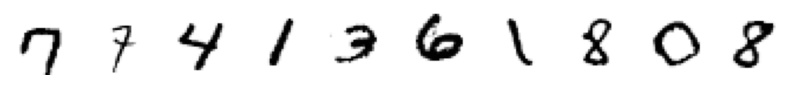

In [2]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

num_examples = 10
fig, axs = plt.subplots(1, num_examples, figsize=(10,100))

rng = jax.random.PRNGKey(0)
idxs = jax.random.randint(rng, (num_examples,), 0, raw_train_images.shape[0])
exs = raw_train_images[idxs,:].reshape((num_examples,28,28))

for i in range(num_examples):
    axs[i].imshow(exs[i, :, :])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_xmargin(0)
    axs[i].set_ymargin(0)

display(HTML("<div style='text-align: center;'>"))
plt.show()
display(HTML("</div>"))


What does our dataset look like? 

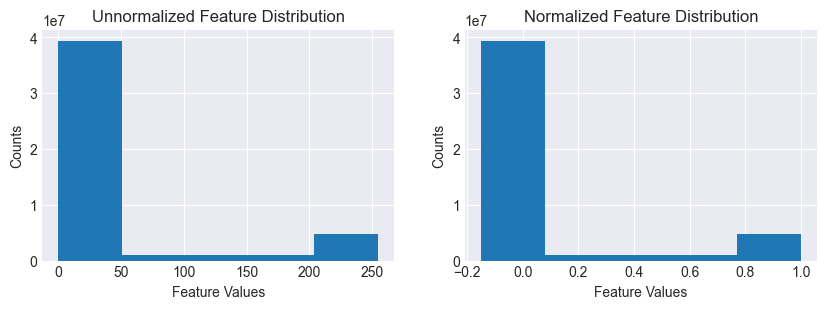

In [28]:
# First, let's plot the histogram for the unnormalized dataset
fig, axs = plt.subplots(1,2, figsize=(10,3))
axs[0].hist(raw_train_images.flatten(), bins=5)
axs[0].set_title("Unnormalized Feature Distribution")
axs[0].set_xlabel("Feature Values")
axs[0].set_ylabel("Counts")

# Let's normalize the  dataset
train_mean = raw_train_images.mean()
train_std = raw_train_images.std()
train_images = (raw_train_images - train_mean)/train_std
train_max = train_images.max()
train_images = train_images/train_max

test_mean = raw_test_images.mean()
test_std = raw_test_images.std()
test_images = (raw_test_images - test_mean)/test_std
test_max = test_images.max()
test_images = test_images/test_max

# Now let's plot the the histogram for the normalized dataset
axs[1].hist(train_images.flatten(), bins=5)
axs[1].set_title("Normalized Feature Distribution")
axs[1].set_xlabel("Feature Values")
axs[1].set_ylabel("Counts")

plt.show()


The unnormalized feature values are a bimodal distribution, with a big peak close to 0 (background) and a small one close to 255 (numeral). After normalization, the distribution is scaled and shifted to the range (-1,1).

### Let's define the models

Our baseline model is a fully-connected network with ReLU activations. The output layer has 10 classes to generate logits for our class probabilities. 
The candidate is a modified version of the baseline with an additional batch normalization layer between each dense and ReLU layer.

In [4]:
from typing import Dict, Any

from functools import reduce
import operator

from time import sleep

from flax import linen as nn
from flax.training import train_state
import optax

rng = jax.random.PRNGKey(42)

class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        outputs = {}
        x = nn.Dense(256)(x)             
        outputs['Dense_0'] = x
        x = nn.relu(x)
        outputs['Relu_0'] = x

        x = nn.Dense(128)(x)              
        outputs['Dense_1'] = x
        x = nn.relu(x)
        outputs['Relu_1'] = x

        x = nn.Dense(64)(x)              
        outputs['Dense_2'] = x
        x = nn.relu(x)
        outputs['Relu_2'] = x

        x = nn.Dense(10)(x)              
        outputs['Dense_3'] = x
        return x, outputs


# Initialize the baseline model
baseline_model = MLP()
dummy_input = jnp.ones((32, 28*28))
baseline_variables = baseline_model.init(rng, dummy_input)
baseline_params = baseline_variables['params']


class MLPBatchNorm(nn.Module):
    @nn.compact
    def __call__(self, x, train: bool = True):
        outputs = {}
        x = nn.Dense(256)(x)             
        outputs['Dense_0'] = x
        x = nn.BatchNorm(use_running_average=not train)(x)  
        outputs['BatchNorm_0'] = x
        x = nn.relu(x)
        outputs['Relu_0'] = x

        x = nn.Dense(128)(x)              
        outputs['Dense_1'] = x
        x = nn.BatchNorm(use_running_average=not train)(x)  
        outputs['BatchNorm_1'] = x
        x = nn.relu(x)
        outputs['Relu_1'] = x

        x = nn.Dense(64)(x)              
        outputs['Dense_2'] = x
        x = nn.BatchNorm(use_running_average=not train)(x)  
        outputs['BatchNorm_2'] = x
        x = nn.relu(x)
        outputs['Relu_2'] = x

        x = nn.Dense(10)(x)              
        outputs['Dense_3'] = x
        return x, outputs

# Initialize the candidate model
candidate_model = MLPBatchNorm()
dummy_input = jnp.ones((32, 28*28))
candidate_variables = candidate_model.init(rng, dummy_input, train=True)
candidate_params = candidate_variables['params']
candidate_batch_stats = candidate_variables['batch_stats']



Let's count the parameters and plot the initial distributions for the parameter values

Number of baseline parameters: 242762
Baseline P/S ratio: 4.0460
Number of candidate parameters: 243658
Candidate P/S ratio: 4.0610


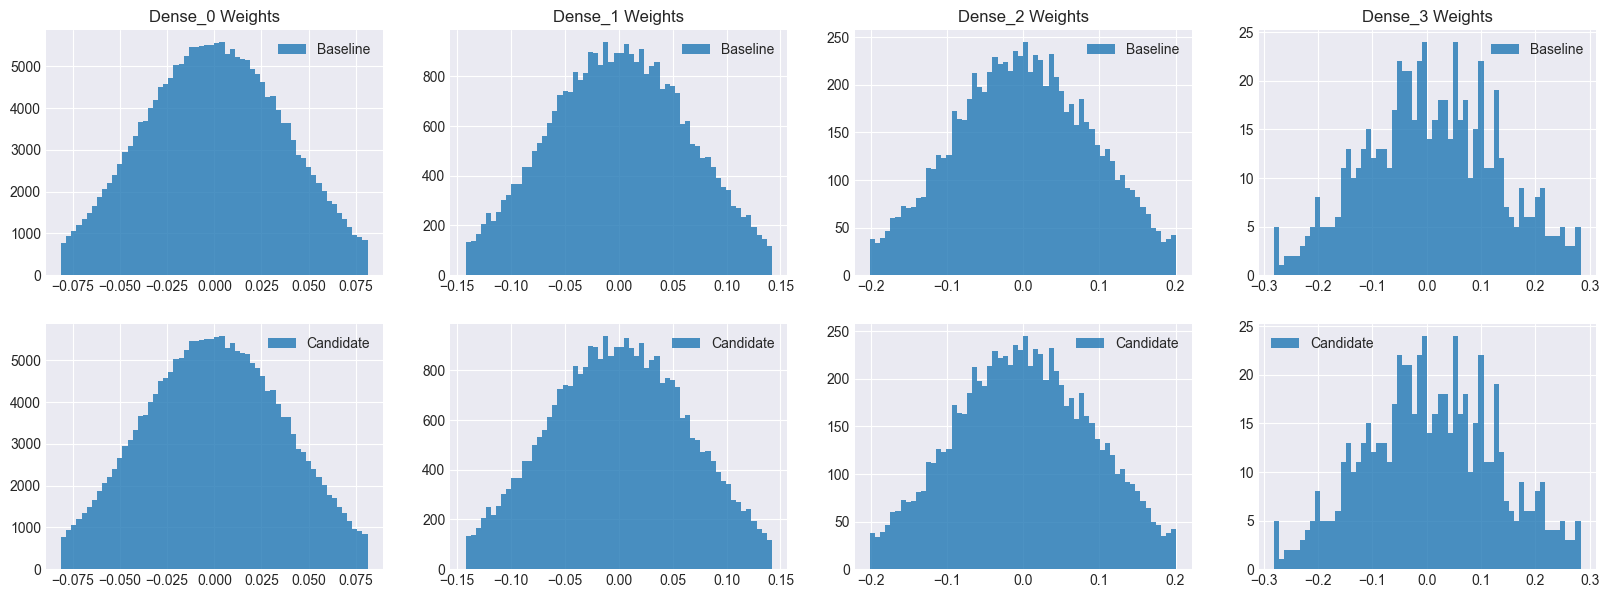

In [23]:

# Count the # of model parameters
def count_params(params):
    num_params = 0
    for layer in params:
        for key in params[layer]:
            shape = params[layer][key].shape
            num_params += reduce(operator.mul, shape)
    return num_params

num_baseline_params = count_params(baseline_params)
num_candidate_params = count_params(candidate_params)

print(f"Number of baseline parameters: {num_baseline_params}")
print(f"Baseline P/S ratio: {num_baseline_params/train_images.shape[0]:0.4f}")
print(f"Number of candidate parameters: {num_candidate_params}")
print(f"Candidate P/S ratio: {num_candidate_params/train_images.shape[0]:0.4f}")

# Lets plot the initial baseline model weight distributions
fig, axs = plt.subplots(2, 4, figsize=[20, 7])

baseline_dense0_w = baseline_params['Dense_0']['kernel'].flatten()
candidate_dense0_w = candidate_params['Dense_0']['kernel'].flatten()

baseline_dense1_w = baseline_params['Dense_1']['kernel'].flatten()
candidate_dense1_w = candidate_params['Dense_1']['kernel'].flatten()

baseline_dense2_w = baseline_params['Dense_2']['kernel'].flatten()
candidate_dense2_w = candidate_params['Dense_2']['kernel'].flatten()

baseline_dense3_w = baseline_params['Dense_3']['kernel'].flatten()
candidate_dense3_w = candidate_params['Dense_3']['kernel'].flatten()

axs[0,0].hist(baseline_dense0_w, bins=60, alpha=0.8)
axs[0,0].set_title("Dense_0 Weights")
axs[0,0].legend(["Baseline"])
axs[0,1].hist(baseline_dense1_w, bins=60, alpha=0.8)
axs[0,1].set_title("Dense_1 Weights")
axs[0,1].legend(["Baseline"])
axs[0,2].hist(baseline_dense2_w, bins=60, alpha=0.8)
axs[0,2].set_title("Dense_2 Weights")
axs[0,2].legend(["Baseline"])
axs[0,3].hist(baseline_dense3_w, bins=60, alpha=0.8)
axs[0,3].set_title("Dense_3 Weights")
axs[0,3].legend(["Baseline"])

axs[1,0].hist(candidate_dense0_w, bins=60, alpha=0.8)
axs[1,0].legend(["Candidate"])
axs[1,1].hist(candidate_dense1_w, bins=60, alpha=0.8)
axs[1,1].legend(["Candidate"])
axs[1,2].hist(candidate_dense2_w, bins=60, alpha=0.8)
axs[1,2].legend(["Candidate"])
axs[1,3].hist(candidate_dense3_w, bins=60, alpha=0.8)
axs[1,3].legend(["Candidate"])



plt.show()

The candidate model has a few more paramters for the batch normalization layers. Note that both models have identical weights before training.

### Let's train the baseline model.

In [6]:
import optax
from flax.training import train_state

rng = jax.random.PRNGKey(42)
LR = 0.001
num_epochs = 20
batch_size = 32

# Create a train state
tx = optax.adam(learning_rate=LR)
baseline_ts = train_state.TrainState.create(apply_fn=baseline_model.apply, params=baseline_params, tx=tx)

def compute_loss(params, apply_fn, images, labels):
    variables = {'params': params}
    logits, updated_variables = apply_fn(variables, images)
    one_hot_labels = jax.nn.one_hot(labels, 10)
    loss = optax.softmax_cross_entropy(logits, one_hot_labels).mean()
    return loss

@jax.jit
def train_step(state, images, labels):
    def loss_fn(params):
        return compute_loss(params, state.apply_fn, images, labels)
    grads = jax.grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return grads, state 

@jax.jit
def eval_step(state, images, labels):
    variables = {'params': state.params}
    logits, outputs = state.apply_fn(variables, images)
    predictions = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(predictions == labels)
    return accuracy, outputs


def train_and_evaluate(rng, model, ts, train_images, train_labels, test_images, test_labels):

    num_train = train_images.shape[0]

    train_accuracy, outputs = eval_step(ts, train_images, train_labels)
    test_accuracy, _ = eval_step(ts, test_images, test_labels)
    print(f'Epoch 0, Train Accuracy: {train_accuracy:0.4f}, Test Accuracy: {test_accuracy:.4f}')
    params_history = [ts.params]
    outputs_history = [outputs]
    grads_history = []

    for epoch in range(num_epochs):

        rng, sub_rng = jax.random.split(rng)
        permutation = jax.random.permutation(sub_rng, num_train)
        train_images = train_images[permutation]
        train_labels = train_labels[permutation]
        
        for i in range(0, num_train, batch_size):
            batch_images = train_images[i:i + batch_size]
            batch_labels = train_labels[i:i + batch_size]
            grads, ts = train_step(ts, batch_images, batch_labels)
            if epoch == 0: 
                grads_history.append(grads)
        train_accuracy, outputs = eval_step(ts, train_images, train_labels)
        test_accuracy, _ = eval_step(ts, test_images, test_labels)
        if epoch % 5 == 0:
            print(f'Epoch {epoch + 1}, Train Accuracy: {train_accuracy:0.4f}, Test Accuracy: {test_accuracy:.4f}')
        params_history.append(ts.params)
        outputs_history.append(outputs)

    return train_accuracy, test_accuracy, grads_history, params_history, outputs_history

train_accuracy, test_accuracy, baseline_grads_history, baseline_params_history, baseline_outputs_history = train_and_evaluate(rng, baseline_model, baseline_ts, train_images, train_labels, test_images, test_labels)
print(f'Epoch {num_epochs}, Train Accuracy: {train_accuracy:0.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch 0, Train Accuracy: 0.1367, Test Accuracy: 0.1449
Epoch 1, Train Accuracy: 0.9645, Test Accuracy: 0.9568
Epoch 6, Train Accuracy: 0.9925, Test Accuracy: 0.9788
Epoch 11, Train Accuracy: 0.9949, Test Accuracy: 0.9807
Epoch 16, Train Accuracy: 0.9949, Test Accuracy: 0.9778
Epoch 20, Train Accuracy: 0.9961, Test Accuracy: 0.9780


### Next, let's train the candidate model.

In [7]:
import optax
from flax.training import train_state

rng = jax.random.PRNGKey(42)
LR = 0.001
num_epochs = 20
batch_size = 32


# Create a train state
tx = optax.adam(learning_rate=LR)
candidate_ts = train_state.TrainState.create(apply_fn=candidate_model.apply, params=candidate_params, tx=tx)

def compute_loss(params, batch_stats, apply_fn, images, labels, train):
    variables = {'params': params, 'batch_stats': batch_stats}
    outputs, updated_variables = apply_fn(variables, images, train=train, mutable=['batch_stats'])
    logits, _ = outputs
    one_hot_labels = jax.nn.one_hot(labels, 10)
    loss = optax.softmax_cross_entropy(logits, one_hot_labels).mean()
    return loss, updated_variables['batch_stats']

@jax.jit
def train_step(state, batch_stats, images, labels):
    def loss_fn(params):
        return compute_loss(params, batch_stats, state.apply_fn, images, labels, train=True)
    grads, updated_batch_stats = jax.grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    return grads, state, updated_batch_stats

@jax.jit
def eval_step(state, batch_stats, images, labels):
    variables = {'params': state.params, 'batch_stats': batch_stats}
    logits, outputs = state.apply_fn(variables, images, train=False)
    predictions = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(predictions == labels)
    return accuracy, outputs


def train_and_evaluate(rng, model, ts, batch_stats, train_images, train_labels, test_images, test_labels):

    num_train = train_images.shape[0]

    train_accuracy, outputs = eval_step(ts, batch_stats, train_images, train_labels)
    test_accuracy, _ = eval_step(ts, batch_stats, test_images, test_labels)
    print(f'Epoch 0, Train Accuracy: {train_accuracy:0.4f}, Test Accuracy: {test_accuracy:.4f}')
    params_history = [ts.params]
    batch_stats_history = [batch_stats]
    outputs_history = [outputs]
    grads_history = []

    for epoch in range(num_epochs):

        rng, sub_rng = jax.random.split(rng)
        permutation = jax.random.permutation(sub_rng, num_train)
        train_images = train_images[permutation]
        train_labels = train_labels[permutation]
        
        for i in range(0, num_train, batch_size):
            batch_images = train_images[i:i + batch_size]
            batch_labels = train_labels[i:i + batch_size]
            grads, ts, batch_stats = train_step(ts, batch_stats, batch_images, batch_labels)
            if epoch == 0:
                grads_history.append(grads)

        train_accuracy, outputs = eval_step(ts, batch_stats, train_images, train_labels)
        test_accuracy, _ = eval_step(ts, batch_stats, test_images, test_labels)
        if epoch % 5 == 0:
            print(f'Epoch {epoch + 1}, Train Accuracy: {train_accuracy:0.4f}, Test Accuracy: {test_accuracy:.4f}')
        params_history.append(ts.params)
        batch_stats_history.append(batch_stats)
        outputs_history.append(outputs)

    return train_accuracy, test_accuracy, grads_history, params_history, batch_stats_history, outputs_history

train_accuracy, test_accuracy, candidate_grads_history, candidate_params_history, candidate_batch_stats_history, candidate_outputs_history = train_and_evaluate(rng, candidate_model, candidate_ts, candidate_batch_stats, train_images, train_labels, test_images, test_labels)

print(f'Epoch {num_epochs}, Train Accuracy: {train_accuracy:0.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch 0, Train Accuracy: 0.1367, Test Accuracy: 0.1449
Epoch 1, Train Accuracy: 0.9762, Test Accuracy: 0.9701
Epoch 6, Train Accuracy: 0.9934, Test Accuracy: 0.9795
Epoch 11, Train Accuracy: 0.9977, Test Accuracy: 0.9838
Epoch 16, Train Accuracy: 0.9987, Test Accuracy: 0.9836
Epoch 20, Train Accuracy: 0.9988, Test Accuracy: 0.9815


As you can see, the candidate model with the batch normalization layers performs better than the baseline, and also converges faster. 

### So why does batch normalization help? 

Let's track the histograms for the activations for each layer over the training epochs.

In [24]:
from matplotlib import colormaps as cm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

layers = ["Dense_0", "Dense_1", "Dense_2"]

fig, axs = plt.subplots(3, 1, figsize=(4,12), constrained_layout=True)

def update(frame):

    for layer_idx, layer in enumerate(layers):
        baseline_outputs = baseline_outputs_history[frame][f"Dense_{layer_idx}"].flatten()
        axs[layer_idx].cla()
        axs[layer_idx].hist(baseline_outputs, color=cm["Blues"](50), bins=60, alpha=1.0)
        candidate_outputs = candidate_outputs_history[frame][f"BatchNorm_{layer_idx}"].flatten()
        axs[layer_idx].hist(candidate_outputs, color=cm["Blues"](90),  bins=60, alpha=1.0)
        axs[layer_idx].set_title(f"{layer} Outputs - Epoch:{frame}")

    for ax in axs:
        ax.margins(x=0, y=0)
        ax.set_xlim(-50, 50)
        ax.legend(["Baseline", "Candidate"])


ani = FuncAnimation(fig, update, frames=len(baseline_outputs_history), interval=300, repeat=True)
plt.close(fig)
video_html = ani.to_html5_video()
video_html_corrected = video_html.replace('<video>', '<video autoplay>')
HTML(video_html_corrected)


### Internal Covariate Shift

As we just observed, in deep networks, the distribution of the inputs to a layer can change quite rapidly and inconsistently, making it more difficult for the model to converge. This is where batch norm helps by ensuring a more consistent and stable distribution for the outputs of a layer (and consequently, the inputs of the subsequent layer).


Notice that both the baseline and candidate activations are identical at the start of training. However, as the training progresses, after each epoch, the baseline model activations tend to shift and spread out. This is called internal covariate shift. On the other hand, notice how stable the outputs for the candidate model's layers are.

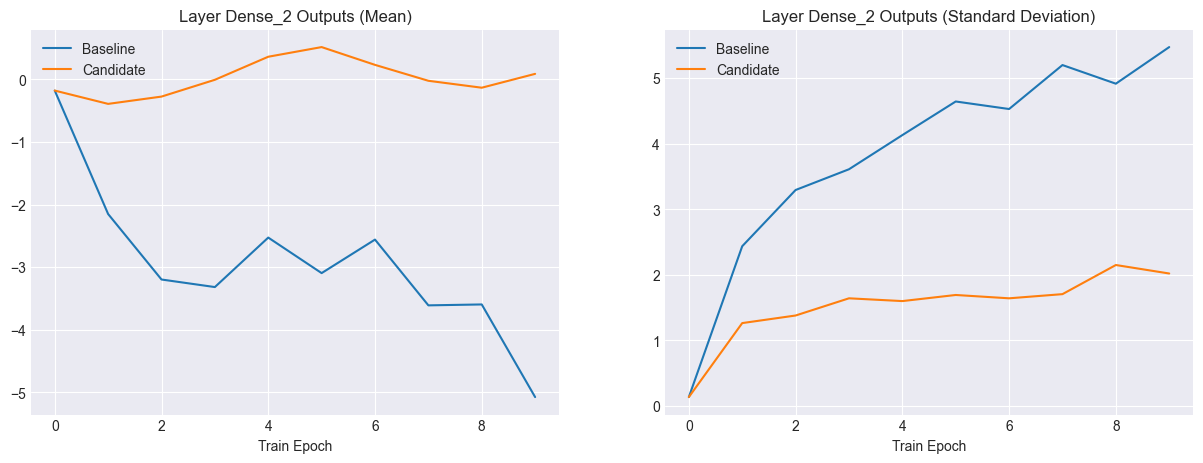

In [19]:
output_idx = 100
layer_name = "Dense_2" 
bins = 60

fig, axs = plt.subplots(1, 2, figsize=(15,5))

baseline_output_means = []
baseline_output_stds = []
candidate_output_means = []
candidate_output_stds = []

for i in range(10):
    baseline_o1 = baseline_outputs_history[i][layer_name][:, output_idx].flatten()
    baseline_m1 = baseline_o1.mean()
    baseline_output_means.append(baseline_m1)
    baseline_s1 = baseline_o1.std()
    baseline_output_stds.append(baseline_s1)

    candidate_o1 = candidate_outputs_history[i][layer_name][:, output_idx].flatten()
    candidate_m1 = candidate_o1.mean()
    candidate_output_means.append(candidate_m1)
    candidate_s1 = candidate_o1.std()
    candidate_output_stds.append(candidate_s1)

axs[0].set_title(f"Layer {layer_name} Outputs (Mean)")
axs[0].set_xlabel("Train Epoch")
axs[0].plot(baseline_output_means)
axs[0].plot(candidate_output_means)

axs[1].set_title(f"Layer {layer_name} Outputs (Standard Deviation)")
axs[1].set_xlabel("Train Epoch")
axs[1].plot(baseline_output_stds)
axs[1].plot(candidate_output_stds)

axs[0].legend(["Baseline", "Candidate"])
axs[1].legend(["Baseline", "Candidate"])

plt.show()

Notice how the output means for the candidate model remain stable and consistent over time. Similarly, note the lower and more consistent standard deviations for the candidate outputs.

### Smoother Gradient Updates

Let's look at how the gradient updates change over time. This time, we will focus on the first epoch only and see what the values of the gradient updates look like.
First, let's choose a single parameter to track.

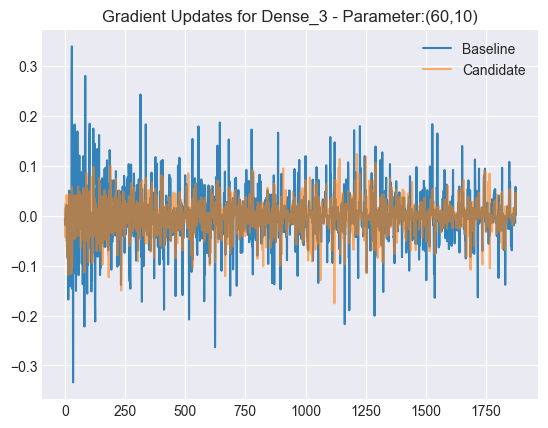

In [20]:
LAYER='Dense_3'
PARAM='kernel'
param_i = 60
param_j = 10 


layer_shape = baseline_params[LAYER][PARAM].shape

baseline_grads = []
baseline_grads_all = []
baseline_grad_means = []
baseline_grad_stds = []
for epoch in range(len(baseline_grads_history)):
    grads = baseline_grads_history[epoch][LAYER][PARAM]
    baseline_grad_means.append(grads.mean())
    baseline_grad_stds.append(grads.std())
    baseline_grads.append(grads[param_i, param_j])
    baseline_grads_all.append(grads)

candidate_grads = []
candidate_grads_all = []
candidate_grad_means = []
candidate_grad_stds = []
for epoch in range(len(candidate_grads_history)):
    grads = candidate_grads_history[epoch][LAYER][PARAM]
    candidate_grad_means.append(grads.mean())
    candidate_grad_stds.append(grads.std())
    candidate_grads.append(grads[param_i, param_j])
    candidate_grads_all.append(grads)

plt.plot(range(len(baseline_grads_history)), baseline_grads, alpha=0.9)
plt.plot(range(len(candidate_grads_history)), candidate_grads, alpha=0.6)
plt.title(f"Gradient Updates for {LAYER} - Parameter:({param_i},{param_j})")
plt.legend(["Baseline", "Candidate"])
plt.show()

Notice that the candidate's gradient updates are a lot smoother than the baseline model's. Next, let's plot the mean and standard deviations for all gradient updates across iterations.

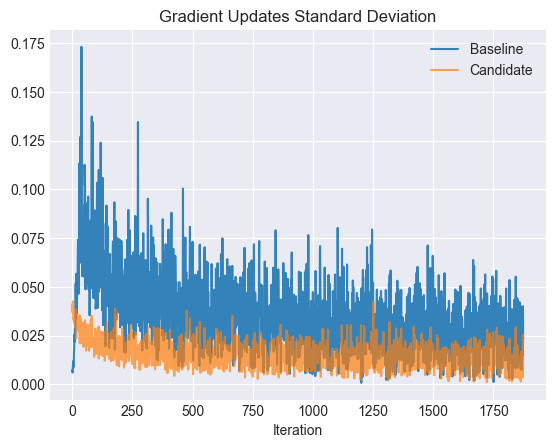

In [11]:
plt.plot(baseline_grad_stds, alpha=0.9)
plt.plot(candidate_grad_stds, alpha=0.7)
plt.title("Gradient Updates Standard Deviation")
plt.legend(["Baseline", "Candidate"])
plt.xlabel("Iteration")
plt.show()

The candidate's gradient updates tend to have smaller standard deviations, especially early in the training. 

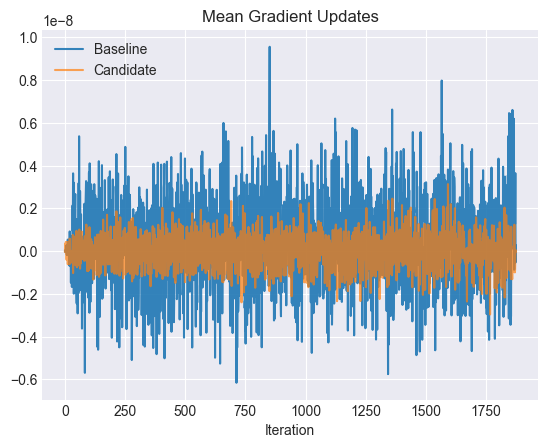

In [12]:
plt.plot(baseline_grad_means, alpha=0.9)
plt.plot(candidate_grad_means, alpha=0.7)
plt.title("Mean Gradient Updates")
plt.legend(["Baseline", "Candidate"])
plt.xlabel("Iteration")
plt.show()

The mean gradient updates for the candidates tend to be smaller as well, leading to a smoother loss surface and faster convergence.